In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.core.display import display, HTML

np.random.seed(42)  # reproducibility

# Switch to a scratch data directory so all paths are local
os.makedirs(os.path.expanduser("~/data/pancan-gtex"), exist_ok=True)
os.chdir(os.path.expanduser("~/data/pancan-gtex"))

In [2]:
# Load the model and predict the test set
model = tf.keras.models.model_from_json(open("models/pancan-gtex-hugo-model.json").read())
model.load_weights("models/pancan-gtex-hugo-weights.h5")
params = json.loads(open("models/pancan-gtex-hugo-params.json").read())

In [7]:
%%time
# Load the compendium
X_all = pd.read_hdf("pancan-gtex-hugo.h5", "samples")
Y = pd.read_hdf("pancan-gtex-hugo.h5", "labels")
print("Loaded {} samples with {} features and {} labels".format(X_all.shape[0], X_all.shape[1], Y.shape[1]))

# Prune so we match the training
X = X_all.drop(labels=(set(X_all.columns) - set(params["genes"])), axis=1)
print("Pruned features down to {} genes".format(X.shape[1]))

Loaded 17277 samples with 44792 features and 40 labels
Pruned features down to 5169 genes
CPU times: user 1.01 s, sys: 4.7 s, total: 5.71 s
Wall time: 5.7 s


In [9]:
sample_id = "TH06_1172_S01"

# Load the sample's expression kallisto TPM output
sample = pd.read_table(os.path.expanduser("~/data/samples/{}/abundance.tsv").format(sample_id), index_col=0, engine='c')\
    .astype(np.float32).T.loc[["tpm"]]

display(HTML("<h1>Focus sample id: {}</h1>".format(sample_id)))

In [13]:
ensemble_to_hugo = pd.read_table("ensemble-to-hugo.tsv", index_col=0)
print("Found {} transcript to hugo mappings".format(ensemble_to_hugo.shape[0]))
print(ensemble_to_hugo.shape)
ensemble_to_hugo.head()

Found 198619 transcript to hugo mappings
(198619, 4)


,chromosome,start,end,gene
transcript,,,,
ENST00000456328.2,chr1,11869,14409,DDX11L1
ENST00000450305.2,chr1,12010,13670,DDX11L1
ENST00000488147.1,chr1,14404,29570,WASH7P
ENST00000619216.1,chr1,17369,17436,MIR6859-1
ENST00000473358.1,chr1,29554,31097,RP11-34P13.3


In [12]:
# Convert from Kallisto ensembl TPM to hugo concordant with the compendium and prune
    
# # Load ensemble to hugo mapping table - see ingest for details
# ensemble_to_hugo = pd.read_csv("ensemble-to-hugo.tsv", sep="\t", index_col=0)
# transcripts = pd.Index([t.split(".")[0] for t in sample.columns])

# missing = len(list(filter(lambda x: x.split(".")[0] not in ensemble_to_hugo.index, sample.columns.values)))
# print("{} transcripts have no hugo mapping".format(missing))

# Create a new dataframe replacing the index
hugo = sample.copy()
hugo.columns = ensemble_to_hugo.reindex(transcripts)["Gene name"].values

# Multiple Ensemble genes map to the same Hugo name. Each of these values has been normalized via log2(TPM+0.001)
# so we convert back into TPM to sum.
hugo_reduced = hugo.groupby(axis="columns", level=0).aggregate(np.sum).sort_index(axis="columns")
print("After collapsing genes we have {} features".format(hugo_reduced.shape[1]))

# Make sure that we end up with the same gene/features as our compendium
assert X_all.columns.equals(hugo_reduced.columns)

# Check that we still sum to roughly 1M net of dropped transcripts due to no mapping
print("sum(tpm):", hugo_reduced.sum(axis="columns"))

# Prune to match training set
sample_features = hugo_reduced.drop(labels=(set(hugo_reduced.columns) - set(params["genes"])), axis=1)
print("Pruned features down to {} genes".format(sample_features.shape[1]))

# Make sure we have the same features in the same order as our training set
assert X.columns.equals(sample_features.columns)

197044 transcripts have no hugo mapping


KeyError: 'Gene name'

## Classification

In [6]:
# predict processes multiple samples and returns a list of predictions
# We just have one so take the first
prediction = model.predict(sample_features)[0]

tumor_normal_prediction_index = int(round(prediction[0]))
tumor_normal_prediction_value = prediction[0]
tumor_normal_prediction_label = params["tumor_normal"][tumor_normal_prediction_index]
display(HTML("<h3>{} with {:.2f} confidence</h3>".format(
    tumor_normal_prediction_label, tumor_normal_prediction_value)))

primary_site_prediction_index = np.argmax(prediction[1:-1])
primary_site_prediction_value = prediction[1:-1][primary_site_prediction_index]
primary_site_prediction_label = params["primary_site"][primary_site_prediction_index]
display(HTML("<h3>{} with {:.2f} confidence".format(
    primary_site_prediction_label, primary_site_prediction_value)))

## Pan disease explanation

In [7]:
import shap
shap.initjs()

# Select a set of background samples of the same disease to take an expectation over
Y_background = Y[(Y._primary_site == primary_site_prediction_label) 
                 & (Y.tumor_normal == tumor_normal_prediction_label)]
X_background = X.loc[Y_background.index]
print("Found {} {} {} training samples".format(
    X_background.shape[0], primary_site_prediction_label, tumor_normal_prediction_label))

Found 469 Skin Tumor training samples


In [8]:
%%time
np.random.seed(42)
background = X_background.iloc[np.random.choice(X_background.shape[0], 200, replace=False)]
print("Randomly selecting {} out of {} {} samples as background to compute an expectatin over".format(
    background.shape[0], X_background.shape[0], primary_site_prediction_label))
explainer = shap.DeepExplainer(model, background)

Randomly selecting 200 out of 469 Skin samples as background to compute an expectatin over
CPU times: user 37.1 ms, sys: 16.6 ms, total: 53.7 ms
Wall time: 19.4 ms


In [9]:
%%time
# Explain predictions of model for our focus sample
sample_shap_values = explainer.shap_values(sample_features.iloc[0:1].values)

CPU times: user 12.2 s, sys: 3.9 s, total: 16.1 s
Wall time: 9.43 s


### Genes driving all possible focus sample classifications

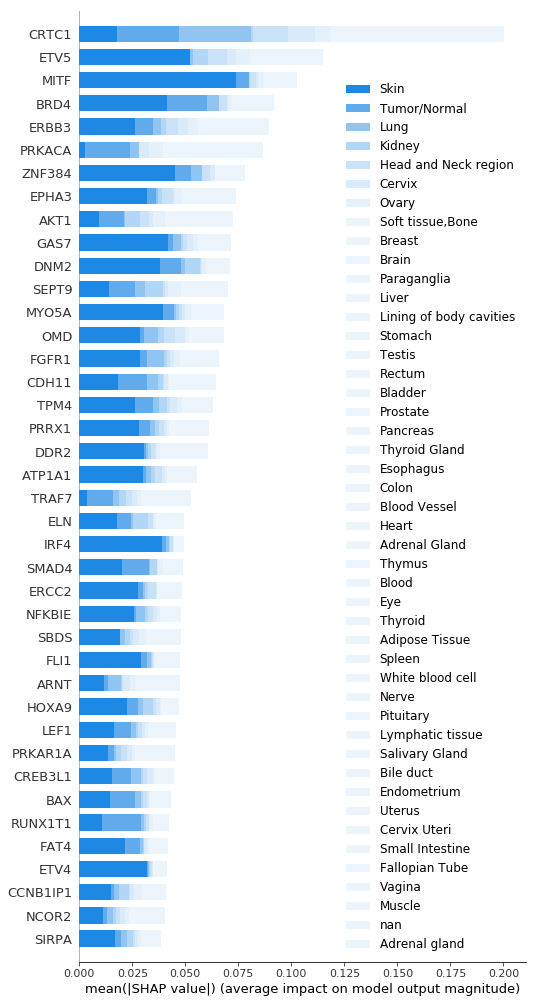

In [10]:
shap.summary_plot(sample_shap_values, background, max_display=40, 
                  class_names=["Tumor/Normal"] + params["primary_site"])

### Genes driving tumor/normal focus sample classification

In [11]:
shap.force_plot(explainer.expected_value[0], sample_shap_values[0], sample_features, link="identity")

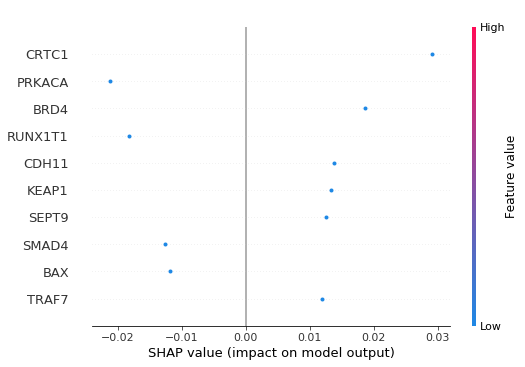

In [12]:
shap.summary_plot(shap_values=sample_shap_values[0], 
                  features=sample_features.iloc[0:1].values, feature_names=params["genes"],
                  max_display=10, class_names=["Tumor/Normal"] + params["primary_site"])

### Genes driving primary site focus sample classification

In [13]:
shap.force_plot(explainer.expected_value[primary_site_prediction_index + 1],
                sample_shap_values[primary_site_prediction_index + 1], 
                sample_features, link="identity")

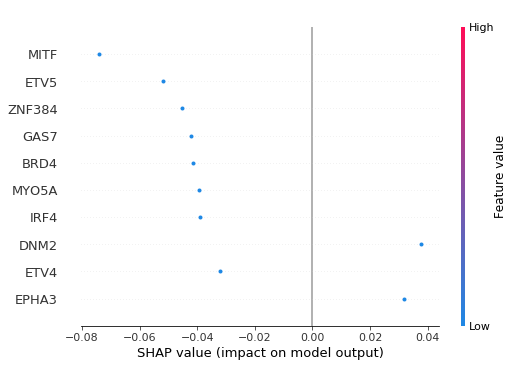

In [14]:
shap.summary_plot(shap_values=sample_shap_values[primary_site_prediction_index + 1], 
                  features=sample_features.iloc[0:1].values, feature_names=params["genes"],
                  max_display=10, class_names=["Tumor/Normal"] + params["primary_site"])

### Enrished pathway identifation from SHAP values
(not complete)
https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-11-574

In [15]:
max_display = 10
# feature_order = np.argsort(np.sum(np.mean(np.abs(sample_shap_values), axis=0), axis=0))
feature_order = np.argsort(abs(sample_shap_values[primary_site_prediction_index + 1][0]))
feature_order = feature_order[-min(max_display, len(feature_order)):]
print("Top gene's driving primary site prediction")
print([params["genes"][i] for i in feature_order])

Top gene's driving primary site prediction
['EPHA3', 'ETV4', 'DNM2', 'IRF4', 'MYO5A', 'BRD4', 'GAS7', 'ZNF384', 'ETV5', 'MITF']


### Genes driving tumor/normal classification for all background samples

In [16]:
%%time
# Explain predictions of model for all background samples
background_shap_values = explainer.shap_values(background.values)

CPU times: user 8min 37s, sys: 6min 26s, total: 15min 4s
Wall time: 52.9 s


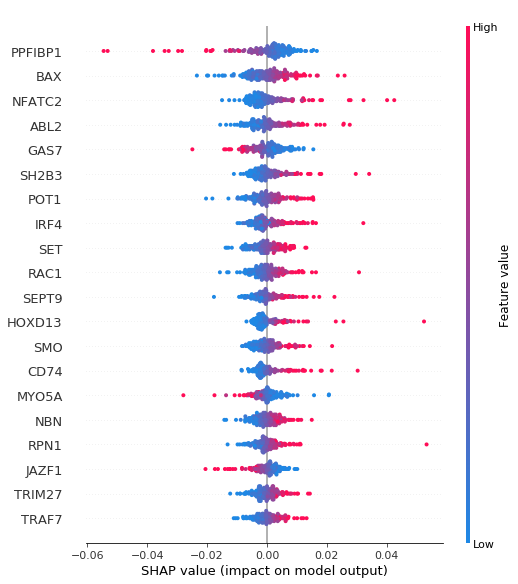

In [17]:
shap.summary_plot(background_shap_values[0], background, plot_type='dot')

### Genes driving primary site classification for all background samples

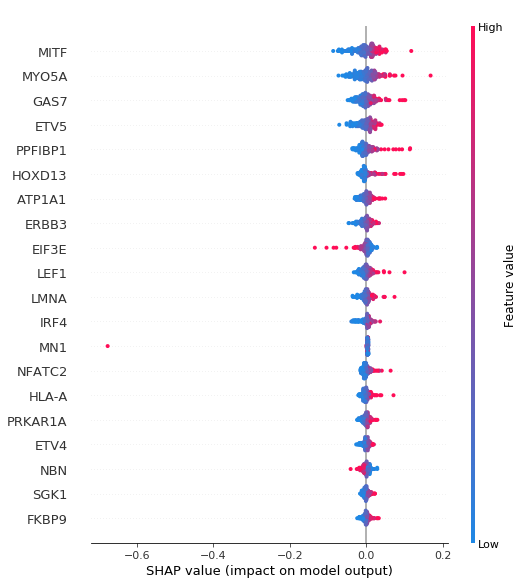

In [18]:
shap.summary_plot(background_shap_values[primary_site_prediction_index + 1], background, plot_type='dot')

## Most Similar Samples
List closest by spearman distance samples from PanCan along with their relevant prognostic endpoints (OSS etc...)

In [20]:
import scipy
import sklearn.metrics.pairwise as sklp

def nearest_samples(cohort, sample, N=-1):
    """
    Compute the Spearman distance between sample and every member of the
    cohort and return the N nearest samples from the cohort.

    cohort, sample: Pandas data frames with columns=features/genes
    N: the number of most similar samples to return
    """
    # Column wise rank transform to turn correlation into spearman
    cohort_transformed = np.apply_along_axis(scipy.stats.rankdata, 1, cohort.values)
    sample_transformed = np.apply_along_axis(scipy.stats.rankdata, 1, sample.values)
    print(cohort_transformed.shape)
    print(sample_transformed.shape)

    # Compute spearman distances
    distances = sklp.pairwise_distances(X=cohort_transformed, Y=sample_transformed, metric="correlation", n_jobs=1)
            
    # Rank and return top N
    rank = 1 - pd.DataFrame(distances, cohort.index.values)
    return rank.sort_values(by=0, ascending=False)[0:N]

nearest = nearest_samples(background, sample_features, 5)
nearest.head()

(200, 700)
(1, 700)


,0
TCGA-W3-A828-06,0.866171
TCGA-D3-A1Q4-06,0.831558
TCGA-WE-A8K5-06,0.824388
TCGA-EB-A42Y-01,0.823063
TCGA-FS-A1ZB-06,0.821814


## Fusions Found (Not Implimented)
Via [Pizzly](https://github.com/pmelsted/pizzly)